In [27]:
import re
import os
import collections
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from scipy.special import digamma
from pathlib import Path
import matplotlib.pyplot as plt

### source: https://towardsdatascience.com/sentencepiece-tokenizer-demystified-d0a3aac19b15

https://huggingface.co/learn/nlp-course/chapter6/7

https://ndingwall.github.io/blog/tokenization

## helpers

In [2]:

# To efficiently determine the next possible words
# We need a Trie data structure
class Trie:
    def __init__(self):
        self.root = {}

    def add(self, word, value):
        node = self.root
        for ch in word:
            if ch not in node:
                node[ch] = {}
            node = node[ch]
        node['<END>'] = value

    def get_value(self, word):
        node = self.root
        for ch in word:
            if ch not in node:
                return 0
            node = node[ch]
        if '<END>' not in node:
            return 0
        return node['<END>']

    def set_value(self, word, value):
        node = self.root
        for ch in word:
            if ch not in node:
                raise ValueError("word not in trie")
            node = node[ch]
        if '<END>' not in node:
            raise ValueError("word not in trie")
        node['<END>'] = value


class SentencePieceTrainer:
    def __init__(self):
        self.trie = None
        self.maxlen = None
        self.vocab_size = None

    def _initialize_trie(self, tokens):
        trie = Trie()
        norm = sum(list(tokens.values()))
        logsum = digamma(norm)

        maxlen = 0
        for tok, val in tokens.items():
            trie.add(tok, digamma(val)-logsum)
            maxlen = max(maxlen, len(tok))

        return trie, maxlen

    def forward_step(self, text, trie):
        N = len(text)

        # d[i] contains the maximum log_prob of any tokenization
        # of text[:i], initialized to 0 (i.e. log(0)=-infty)
        d = [-np.inf]*(N+1)

        # p[i] (stands for parent) contains the number of characters of
        # the final token in the most likely sequence that ends at index i
        p = [None]*(N+1)
        d[0]=0

        for i in range(1, N+1):

            # find all possible final words. Have to look back
            # a distance set by the length of the longest token
            for j in range(max(i-self.maxlen, 0), i):

                final_token = text[j:i]
                final_value = trie.get_value(final_token)

                # if the current ending word has a higher log-probability,
                # save that value and store the word (i.e. # chars to backtrack)
                if final_value and d[j]+final_value > d[i]:
                    d[i] = d[j]+final_value
                    p[i] = len(final_token)
            if p[i] is None:
                raise ValueError(f"Encountered unknown token '{text[i-1]}'.")

        loss = d[-1]
        return loss, p

    def backward_step(self, text, p):
        idx = len(p)
        tokenization = []
        while idx > 1:
            # move back the number of steps p tells you to
            next_idx = idx-p[idx-1]

            # extract the final token
            tok = text[next_idx-1:idx-1]
            tokenization.append(tok)

            idx = next_idx
        tokenization = list(reversed(tokenization))
        return tokenization

    def E_step(self, tokenization, trie):
        # get the new token counts based on updated tokenization
        counts = collections.Counter(tokenization)
        norm = sum(list(counts.values()))

        # Bayesianify them: https://cs.stanford.edu/~pliang/papers/tutorial-acl2007-talk.pdf
        # https://github.com/google/sentencepiece/blob/master/src/unigram_model_trainer.cc
        # we are returning the log probabilties here (alpha=0 prior)
        logsum = digamma(norm)
        for k, v in counts.items():
            counts[k] = digamma(v)-logsum

        for k, v in counts.items():
            trie.set_value(k, v)
        return trie

    def M_step(self, text, trie):
        loss, p = self.forward_step(text, trie)
        tokenization = self.backward_step(text, p)
        return tokenization, loss

    def EM_step(self, text, tokenization, trie):
        trie = self.E_step(tokenization, trie)
        tokenization, loss = self.M_step(text, trie)
        return loss, tokenization, trie

    def EM_round(self, text, tokens, delta=0.01, max_iter=10):
        tokenization, old_loss = self.M_step(text, self.trie)
        for step in range(max_iter):
            print(f"EM iter {step}: ", end='')
            loss, tokenization, trie = self.EM_step(text, tokenization, self.trie)
            print(f"Loss={loss:.2f}")
            if abs(old_loss-loss) < delta:
                break
            old_loss = loss

    def prune_tokens(self, tokens, characters, vocab_size, trim_frac=0.2):
        """ Tokens are passed by reference and modified in place.
        Returns:
            True: to indicate to caller that more rounds are needed
            False: to indicate we successfully hit the target vocab size
            ValueError: if the vocab size cannot be reached."""
        sorted_tokens = tokens.most_common()
        N = len(sorted_tokens)
        n_trim = int(trim_frac*N)
        for i in reversed(range(N)):
            if N <= vocab_size:
                return False
            if n_trim <= 0:
                return True
            tok = sorted_tokens[i][0]
            if tok not in characters:
                self.trie.set_value(tok, 0) # we need to delete it from the trie (that sticks around)
                tokens.pop(tok) # also need to delete from tokens, so the next round doesn't see it
                n_trim -= 1
                N -= 1
        if n_trim > 0:
            raise ValueError('Could not reduce tokens further. Please increase vocab size')
        return False

    def fit(self, text, tokens, characters, vocab_size, delta=0.01, max_iter=5, max_rounds=5):
        """ To turn off pruning, just set max_rounds=1 """
        text = re.sub(' ', '_', text)
        if vocab_size > len(tokens):
            raise ValueError(f"Vocab size is larger than the availble number of tokens {len(tokens)}.")
        self.trie, self.maxlen = self._initialize_trie(tokens)
        for i in range(1, max_rounds+1):
            print(f"--- Round {i}. Vocab size: {len(tokens)} ---")
            self.EM_round(text, tokens, delta, max_iter)
            if not self.prune_tokens(tokens, characters, vocab_size):
                break
        self.vocab_size = len(tokens)

    def generalized_forward_step(self, text, trie, nbest_size=1):
        N = len(text)
        d = [-np.inf]*(N+1)
        p = [None]*(N+1)
        d[0]=0
        for i in range(1, N+1):
            d_queue = []
            p_queue = []
            for j in range(max(i-self.maxlen, 0), i):
                final_token = text[j:i]
                final_value = trie.get_value(final_token)
                if final_value:
                    curr_d = d[j]+final_value
                    curr_p = len(final_token)
                    d[i] = max(d[i], curr_d)
                    d_queue.append(curr_d)
                    p_queue.append(curr_p)
            ids = np.argsort(d_queue)[-nbest_size:]
            p[i] = [p_queue[z] for z in ids]
        return p

    def generalized_backward_step(self, text, p):
        idx = len(p)
        tokenization = []
        while idx > 1:
            back_steps = np.random.choice(p[idx-1])
            next_idx = idx-back_steps
            tok = text[next_idx-1:idx-1]
            tokenization.append(tok)
            idx = next_idx
        tokenization = list(reversed(tokenization))
        return tokenization

    def tokenize(self, text, nbest_size=1):
        text = re.sub(' ', '_', text)
        if self.trie is None:
            raise ValueError("Trainer has not yet been fit. Cannot tokenize.")
        p = self.generalized_forward_step(text, self.trie, nbest_size)
        tokenization = self.generalized_backward_step(text, p)
        return tokenization

In [3]:
class BytePairEncoder:
    def __init__(self):
        self.merges = None
        self.characters = None
        self.tokens = None
        self.vocab = None

    def format_word(self, text, space_token='_'):
        return ' '.join(list(text)) + ' ' + space_token

    def initialize_vocab(self, text):
        text = re.sub('\s+', ' ', text)
        all_words = text.split()
        vocab = {}
        for word in all_words:
            word = self.format_word(word)
            vocab[word] = vocab.get(word, 0) + 1
        tokens = collections.Counter(text)
        return vocab, tokens

    def get_bigram_counts(self, vocab):
        pairs = {}
        for word, count in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pair = (symbols[i], symbols[i+1])
                pairs[pair] = pairs.get(pair, 0) + count
        return pairs

    def merge_vocab(self, pair, vocab_in):
        vocab_out = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        bytepair = ''.join(pair)
        for word in vocab_in:
            w_out = p.sub(bytepair, word)
            vocab_out[w_out] = vocab_in[word]
        return vocab_out, (bigram, bytepair)

    def find_merges(self, vocab, tokens, num_merges):
        merges = []
        for i in range(num_merges):
            pairs = self.get_bigram_counts(vocab)
            best_pair = max(pairs, key=pairs.get)
            best_count = pairs[best_pair]
            vocab, (bigram, bytepair) = self.merge_vocab(best_pair, vocab)
            merges.append((r'(?<!\S)' + bigram + r'(?!\S)', bytepair))
            tokens[bytepair] = best_count
        return vocab, tokens, merges

    def fit(self, text, num_merges):
        vocab, tokens = self.initialize_vocab(text)
        self.characters = set(tokens.keys())
        self.vocab, self.tokens, self.merges = self.find_merges(vocab, tokens, num_merges)

## Train sentencepiece model

In [4]:
import sentencepiece as spm

# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train('--input=data/botchan.txt --model_prefix=m --vocab_size=2000')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([208, 31, 9, 434, 601]))

['▁This', '▁is', '▁a', '▁t', 'est']
[208, 31, 9, 434, 601]
This is a test
This is a test


In [5]:
sp.vocab_size()

2000

## Use sample code

In [6]:
txt=Path('data/botchan.txt').read_text()

txt = txt.replace('\n', ' ')
txt = re.sub(' +', ' ', txt)

In [7]:
bpe_enc=BytePairEncoder()
bpe_enc.fit(txt, 2000)

In [8]:
len(bpe_enc.vocab), len(bpe_enc.tokens)

(9184, 2086)

In [9]:
sp.vocab_size()

2000

In [10]:
sp_trainer=SentencePieceTrainer()

tokens = bpe_enc.tokens
tokens['_'] = tokens[' ']
tokens.pop(' ')

characters = bpe_enc.characters
characters.discard(' ')
characters.add('_')

sp_trainer.fit(txt, tokens, characters, vocab_size=1000)

--- Round 1. Vocab size: 2086 ---
EM iter 0: Loss=-521922.71
EM iter 1: Loss=-516140.23
EM iter 2: Loss=-514884.59
EM iter 3: Loss=-514630.88
EM iter 4: Loss=-514542.31
--- Round 2. Vocab size: 1669 ---
EM iter 0: Loss=-532336.51
EM iter 1: Loss=-532287.26
EM iter 2: Loss=-532266.59
EM iter 3: Loss=-532257.56
EM iter 4: Loss=-532253.39
--- Round 3. Vocab size: 1336 ---
EM iter 0: Loss=-550416.89
EM iter 1: Loss=-550285.50
EM iter 2: Loss=-550252.74
EM iter 3: Loss=-550248.48
EM iter 4: Loss=-550248.16
--- Round 4. Vocab size: 1069 ---
EM iter 0: Loss=-568226.50
EM iter 1: Loss=-568159.01
EM iter 2: Loss=-568142.14
EM iter 3: Loss=-568126.77
EM iter 4: Loss=-568125.89


### tokenize text

In [34]:
nbest_size = 3
string = 'hello world'
for i in range(3):
    x = sp_trainer.tokenize('hello world', nbest_size=nbest_size)
    print(f"Sample {i+1}: {x}")

Sample 1: ['h', 'e', 'l', 'l', 'o_', 'w', 'o', 'r', 'ld']
Sample 2: ['h', 'e', 'll', 'o', '_', 'w', 'o', 'r', 'l', 'd']
Sample 3: ['he', 'l', 'lo', '_', 'w', 'o', 'r', 'ld']


In [36]:
print("Original string:", string)
x = sp_trainer.tokenize('hello world', nbest_size=nbest_size)
print("Reconstructed string:", ''.join(x).replace('_', ' '))

Original string: hello world
Reconstructed string: hello world


## Another example

https://everdark.github.io/k9/notebooks/ml/natural_language_understanding/subword_units/subword_units.nb.html#12_probablistic_subword_segmentation

### data

In [11]:
txt=Path('data/botchan.txt').read_text()

### initial BPE tokenization

In [20]:
class BPE:

  def __init__(self, sents, min_cnt=3, verbose=False):
    self.verbose = verbose
    init_vocab = defaultdict(int)
    for sent in sents:
      words = re.split(r"\W+", sent)
      for w in words:
        if w != "":
          init_vocab[w] += 1
    # Create fullword vocabulary.
    self.word_vocab = {k: v for k, v in init_vocab.items() if v >= min_cnt}
    # Insert space between each char in a word for latter ease of merge operation.
    # We directly borrow the idea from https://www.aclweb.org/anthology/P16-1162.
    self.working_vocab = {" ".join(k): v for k, v in self.word_vocab.items()}
    self.subword_vocab = defaultdict(int)
    # Also build a character-level vocabulary as the base subwords.
    self.char_vocab = defaultdict(int)
    for sent in sents:
      for char in list(sent):
        self.char_vocab[char] += 1

  def _find_top_subword(self):
    subword_pairs = defaultdict(int)
    for w, cnt in self.working_vocab.items():
      subw = w.split()
      for i in range(len(subw) - 1):
        # Count bigrams.
        subword_pairs[subw[i], subw[i+1]] += cnt
    top_subw_pair = max(subword_pairs, key=subword_pairs.get)
    top_subw = "".join(top_subw_pair)
    self.subword_vocab[top_subw] = subword_pairs[top_subw_pair]
    if self.verbose:
      print("New subword added: {}".format(top_subw))
    return top_subw_pair

  def _merge(self, subw_pair):
    bigram = re.escape(" ".join(subw_pair))
    p = re.compile(r"(?<!\S)" + bigram + r"(?!\S)")
    self.working_vocab = {p.sub("".join(subw_pair), w): cnt for w, cnt in self.working_vocab.items()}
  
  def update_subword(self, n_merge=1):
    for n in range(n_merge):
      top_subw_pair = self._find_top_subword()
      self._merge(top_subw_pair)

In [21]:
# Build a seeding subword vocabulary using BPE.
# For illustration purpose we didn't go for a huge seeding size.
# In actual application the seeding vocabulary should be much larger than what we have here.
bpe = BPE(txt.lower().split('\n'), min_cnt=1)
bpe.update_subword(n_merge=2000)

### build subword log probability

In [22]:
def subword_count(char_vocab, subword_vocab):
    subword_cnt = {**char_vocab, **subword_vocab}
    tot_cnt = np.sum(list(subword_cnt.values()))

    # The initial estimate of subword probability.
    subword_logp = {k: np.log(v / tot_cnt) for k, v in subword_cnt.items()}
    return subword_logp

subword_logp=subword_count(bpe.char_vocab, bpe.subword_vocab)

### create a viterbi forward algorithm

In [23]:
def viterbi_forward(word, subword_logp):
    """Forward step of Viterbi given a single word."""
    # Create storage array for best substring recorded at each end-of-character position.
    best_subw_slices = [None] * (len(word) + 1)
    neg_loglik = np.zeros(len(word) + 1)
    # Search the best substring given every possible end of position along the word.
    for eow in range(1, len(word) + 1):
        # For every end-of-word position:
        neg_loglik[eow] = np.inf
        for bow in range(eow):
            # For every possible beginning-of-word position given the end-of-word position:
            subw = word[bow:eow]
            if subw in subword_logp:
                logp = subword_logp[subw]
                # Compute subword probability:
                # P(current segment) + P(the best segment just before the current segment).
                s = neg_loglik[bow] - logp
                if s < neg_loglik[eow]:
                    neg_loglik[eow] = s
                    best_subw_slices[eow] = (bow, eow)
    return neg_loglik, best_subw_slices

##### visualize viterbi

In [24]:
w='whereby'
subw_scores, subw_slices = viterbi_forward(w, subword_logp)
subw = [w[idx[0]:idx[1]] for idx in subw_slices if idx is not None]
print(subw)  # Best segmented subword at each subword end.

['w', 'wh', 'e', 'er', 'where', 'b', 'by']


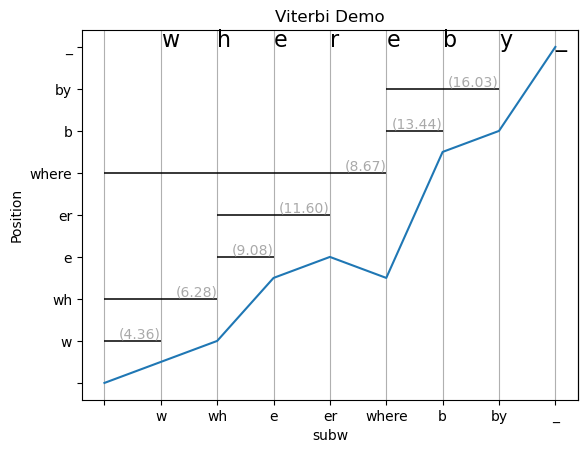

In [28]:

#make df
subw_demo = pd.DataFrame(subw_slices[1:], columns=['start', 'end'])
subw_demo['subw'] = subw
subw_demo = pd.concat([pd.DataFrame([[0, 0, ""]], columns=['start', 'end', 'subw']), subw_demo])
subw_demo = pd.concat([subw_demo, pd.DataFrame([[subw_demo.shape[0], subw_demo.shape[0], "_"]], 
                                               columns=['start', 'end', 'subw'])])
subw_demo['subw'] = pd.Categorical(subw_demo['subw'], categories=subw_demo['subw'].unique()[::-1])
subw_demo['score'] = subw_scores.tolist()[1:] + [0, 0]
subw_demo=subw_demo.reset_index()

w_df = pd.DataFrame({'x': [''] * (len(subw_demo) - 2), 'y': np.arange(len(subw_demo) - 2) + 0.5,
                     'label': list(w)})
#plot
plt.plot(subw_demo['subw'], (subw_demo['start'] + subw_demo['end']) / 2, '', markersize=8, label='subw'),
plt.hlines(subw_demo['subw'], subw_demo['start'], subw_demo['end'], colors='black', linewidth=1.1),

ends=subw_demo.loc[1:(len(subw_demo))-1, 'end'].tolist()
subws=subw_demo.loc[1:(len(subw_demo) - 1), 'subw'].tolist()
scores=[f"({score:.2f})" for score in subw_scores.tolist()[1:]]
for i, el in enumerate(ends[:-1]):
    plt.text(subws[i], ends[i], scores[i],  va='bottom', ha='right', fontsize=10, color='darkgrey')

for i, row in w_df.iterrows():
    plt.text(i+1, 8, row['label'], fontsize=16)

plt.text(8, subw_demo.shape[0]-1, '_', fontsize=16)

plt.gca().secondary_yaxis('right').set_ticks([]),
plt.grid(which='major', axis='x')
plt.title('Viterbi Demo')
plt.xlabel('subw')
plt.ylabel('Position')
plt.show()

### create viterbi backward algorithm

In [29]:
def viterbi_backward(word, subw_slices):
    """Backward step of Viterbi to return the best path."""
    subwords = []
    subword_slices = []
    next_slices = subw_slices[-1]
    while next_slices is not None:
        subw = word[next_slices[0]:next_slices[1]]
        subwords.append(subw)
        subword_slices.append(next_slices)
        next_slices = subw_slices[next_slices[0]]
    subwords.reverse()
    return subwords, subword_slices


# Test with a single word.
best_subw, best_slices = viterbi_backward(w, subw_slices)
print(best_subw)

['where', 'by']


In [30]:
def viterbi(line, subword_logp):
    out = []
    words = line.split()
    for w in words:
        subw_scores, subw_slices = viterbi_forward(w, subword_logp)
        subw, subw_idx = viterbi_backward(w, subw_slices)
        out.extend(subw)
    return out

### example to run and prune vocabulary

Here is the complete procedure:

- Initialize a large seeding subword vocabulary from the training corpus
- [Expectation] Estimate each subword probability by the corresponding frequency counts in the vocabulary
- [Maximization] Use Viterbi to segment the corpus, returning the optimal segments
- Compute the loss of each new subword from optimal segments
- Shrink the vocabulary size by dropping the subwords with top X% smallest losses
- Repeat step 2 to 5 until the vocabulary size reaches a desired number

The loss of a subword in step 4 is the reduction in overall training corpus segment likelihood if that subword is removed from the current vocabulary.

In [31]:
max_vocab=1000
share2remove=.1 #in each iteration what share of vocab is removed
lines= txt.lower().split('\n')
#initial vocab
char_vocab=bpe.char_vocab
subword_vocab= bpe.subword_vocab
subword_logp=subword_count(char_vocab, subword_vocab)


while len(subword_vocab)>max_vocab:
    #tokenize with existing tokenizer
    all_line_tokens=[]
    for line in lines:
        line_toks=viterbi(line, subword_logp)
        all_line_tokens.extend(line_toks)
    #count new subword vocab and logp
    subword_vocab=Counter(all_line_tokens)
    subword_logp_after=subword_count({}, subword_vocab)
    
    loss = {k: subword_vocab[k]*v for k, v in subword_logp_after.items()}
    print(f'loss old {sum(loss.values())}')
    loss= sorted(loss.items(), key=lambda v: v[1], reverse=True)
    
    n_remove=int(len(loss)*share2remove)
    cnt=0
    loss_new=dict()
    subword_vocab_after={}
    for i, el in enumerate(loss):
        if len(el[0])>1 and cnt<n_remove: #keep tokens len 1
            cnt+=1
        else:
            loss_new[el[0]]=el[1]*subword_vocab[el[0]]
            subword_vocab_after[el[0]]=subword_vocab[el[0]]
    
    print(f'loss new {sum(loss_new.values())}')
    print(f'len vocab {len(subword_vocab_after)}')
            
    subword_logp=subword_count({}, subword_vocab_after)
    subword_vocab=subword_vocab_after.copy()


loss old -450700.09105841507
loss new -243167675.6870317
len vocab 1496
loss old -451368.4767225382
loss new -247140173.9623974
len vocab 1345
loss old -455957.07101278956
loss new -256559739.6128888
len vocab 1211
loss old -461825.5497780338
loss new -268822269.2108912
len vocab 1090
loss old -468590.5479680333
loss new -283891192.3831789
len vocab 981


In [32]:
viterbi(w, subword_logp)

['where', 'by']

In [33]:
viterbi('collection', subword_logp)

['coll', 'e', 'ction']